# Проверочная работа. Предсказание анализа биоптата молочных желез

Описание задания: 
1. Загрузить файл data_breast.csv. В данном файле собрана расчетная информация с обработанных изображений биоптата молочных желез женщин. Задача заключается в предсказании переменной “Diagnosis” - является ли содержимое биоптата доброкачественным (значение “B” – benign) либо злокачественным (значение “M” – malicious). Описание данных доступно на сайте https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29
2. Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).
3. Выбрать стратегию для работы с пропущенными значениями.
4. Рассчитать и визуализировать корреляционную матрицу для переменных.
5. Визуализировать взаимосвязи между переменными.
6. С помощью статистических методов проверить взаимосвязи между переменными.
7. Выбрать стратегию Feature Selection – сокращение размерности либо генерация новых переменных. Какой из этих
двух подходов даст лучший результат при классификации?
8. Провести стратегию Oversampling/Undersampling, проверить дает ли она улучшение результатов.
9. Сделать кросс-валидацию данных с использованием подхода K-fold (n_folds=10).
10. Рассчитать Feature Selection для выбранных переменных.
11. Решить задачу бинарной классификации и предсказать переменную ”Diagnosis ” протестировав как минимум 2
алгоритма. Использовать те алгоритмы, которые позволяют предсказать вероятность класса (proba). Рассчитать и
вывести вероятность каждого класса.
12. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall
13. Проверить качество вероятности класса с использованием метрики: Brier Score
14. * Осуществить запуск вашего скрипта с использованием Docker.
15. Загрузить результат (в формате .ipynb ноутбука либо докер реализации) в репозиторий. Разместить ссылку в лк

## 0. Импорт библиотек

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# Модель
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Метод кросс-валидации
#from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Статистические проверки
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Функция дл чтения данных из строки
from io import StringIO

## 1. Загрузка данных

In [2]:
data = pd.read_csv('data_breast.csv')
data = data.drop('Unnamed: 32', axis=1)
data['diagnosis'] = data.apply(lambda x: 1 if x['diagnosis']=="M" else 0, axis=1)
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
diagnosis                  569 non-null int64
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave_points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-

## 2. Расчет основных статистик 
#### (среднее, медиана, мода, мин/макс, сред. отклонение)

In [4]:
# Расчитываем основные статистики для средних значений измерений
def describe(df, stats):
    d = df.describe()
    return d.append(df.agg(stats))

describe(data[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean']], ['median'])


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440
median,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540


## 3. Заполнение пропущенных значений
##### Пропущенных значений нет

## 4. Корреляция переменных

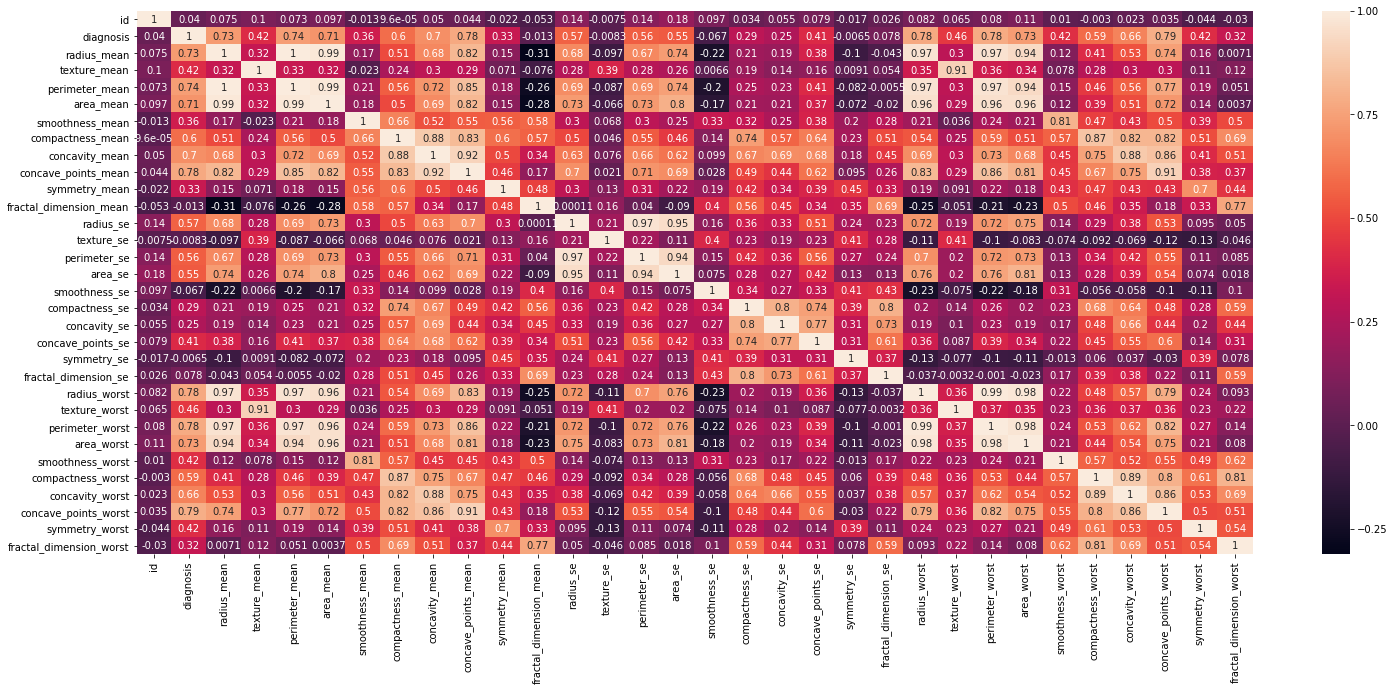

In [5]:
# Общая матрица корреляции
plt.figure(figsize=(25,10))
sns.heatmap(data.corr(), annot=True)

In [6]:
# Оцениваем корреляцию признаков с target-переменной
data.corr()[['diagnosis']].sort_values(by='diagnosis', ascending=False).style.bar()

,diagnosis
diagnosis,1
concave_points_worst,0.793566
perimeter_worst,0.782914
concave_points_mean,0.776614
radius_worst,0.776454
perimeter_mean,0.742636
area_worst,0.733825
radius_mean,0.730029
area_mean,0.708984
concavity_mean,0.69636


## 5. Взаимосвязь между переменными
#### Анализируем зависимости между средними значениями переменных

In [7]:
means = data[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean']]

worst = data[['radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst']]

std = data[['radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se',
       'symmetry_se', 'fractal_dimension_se']]

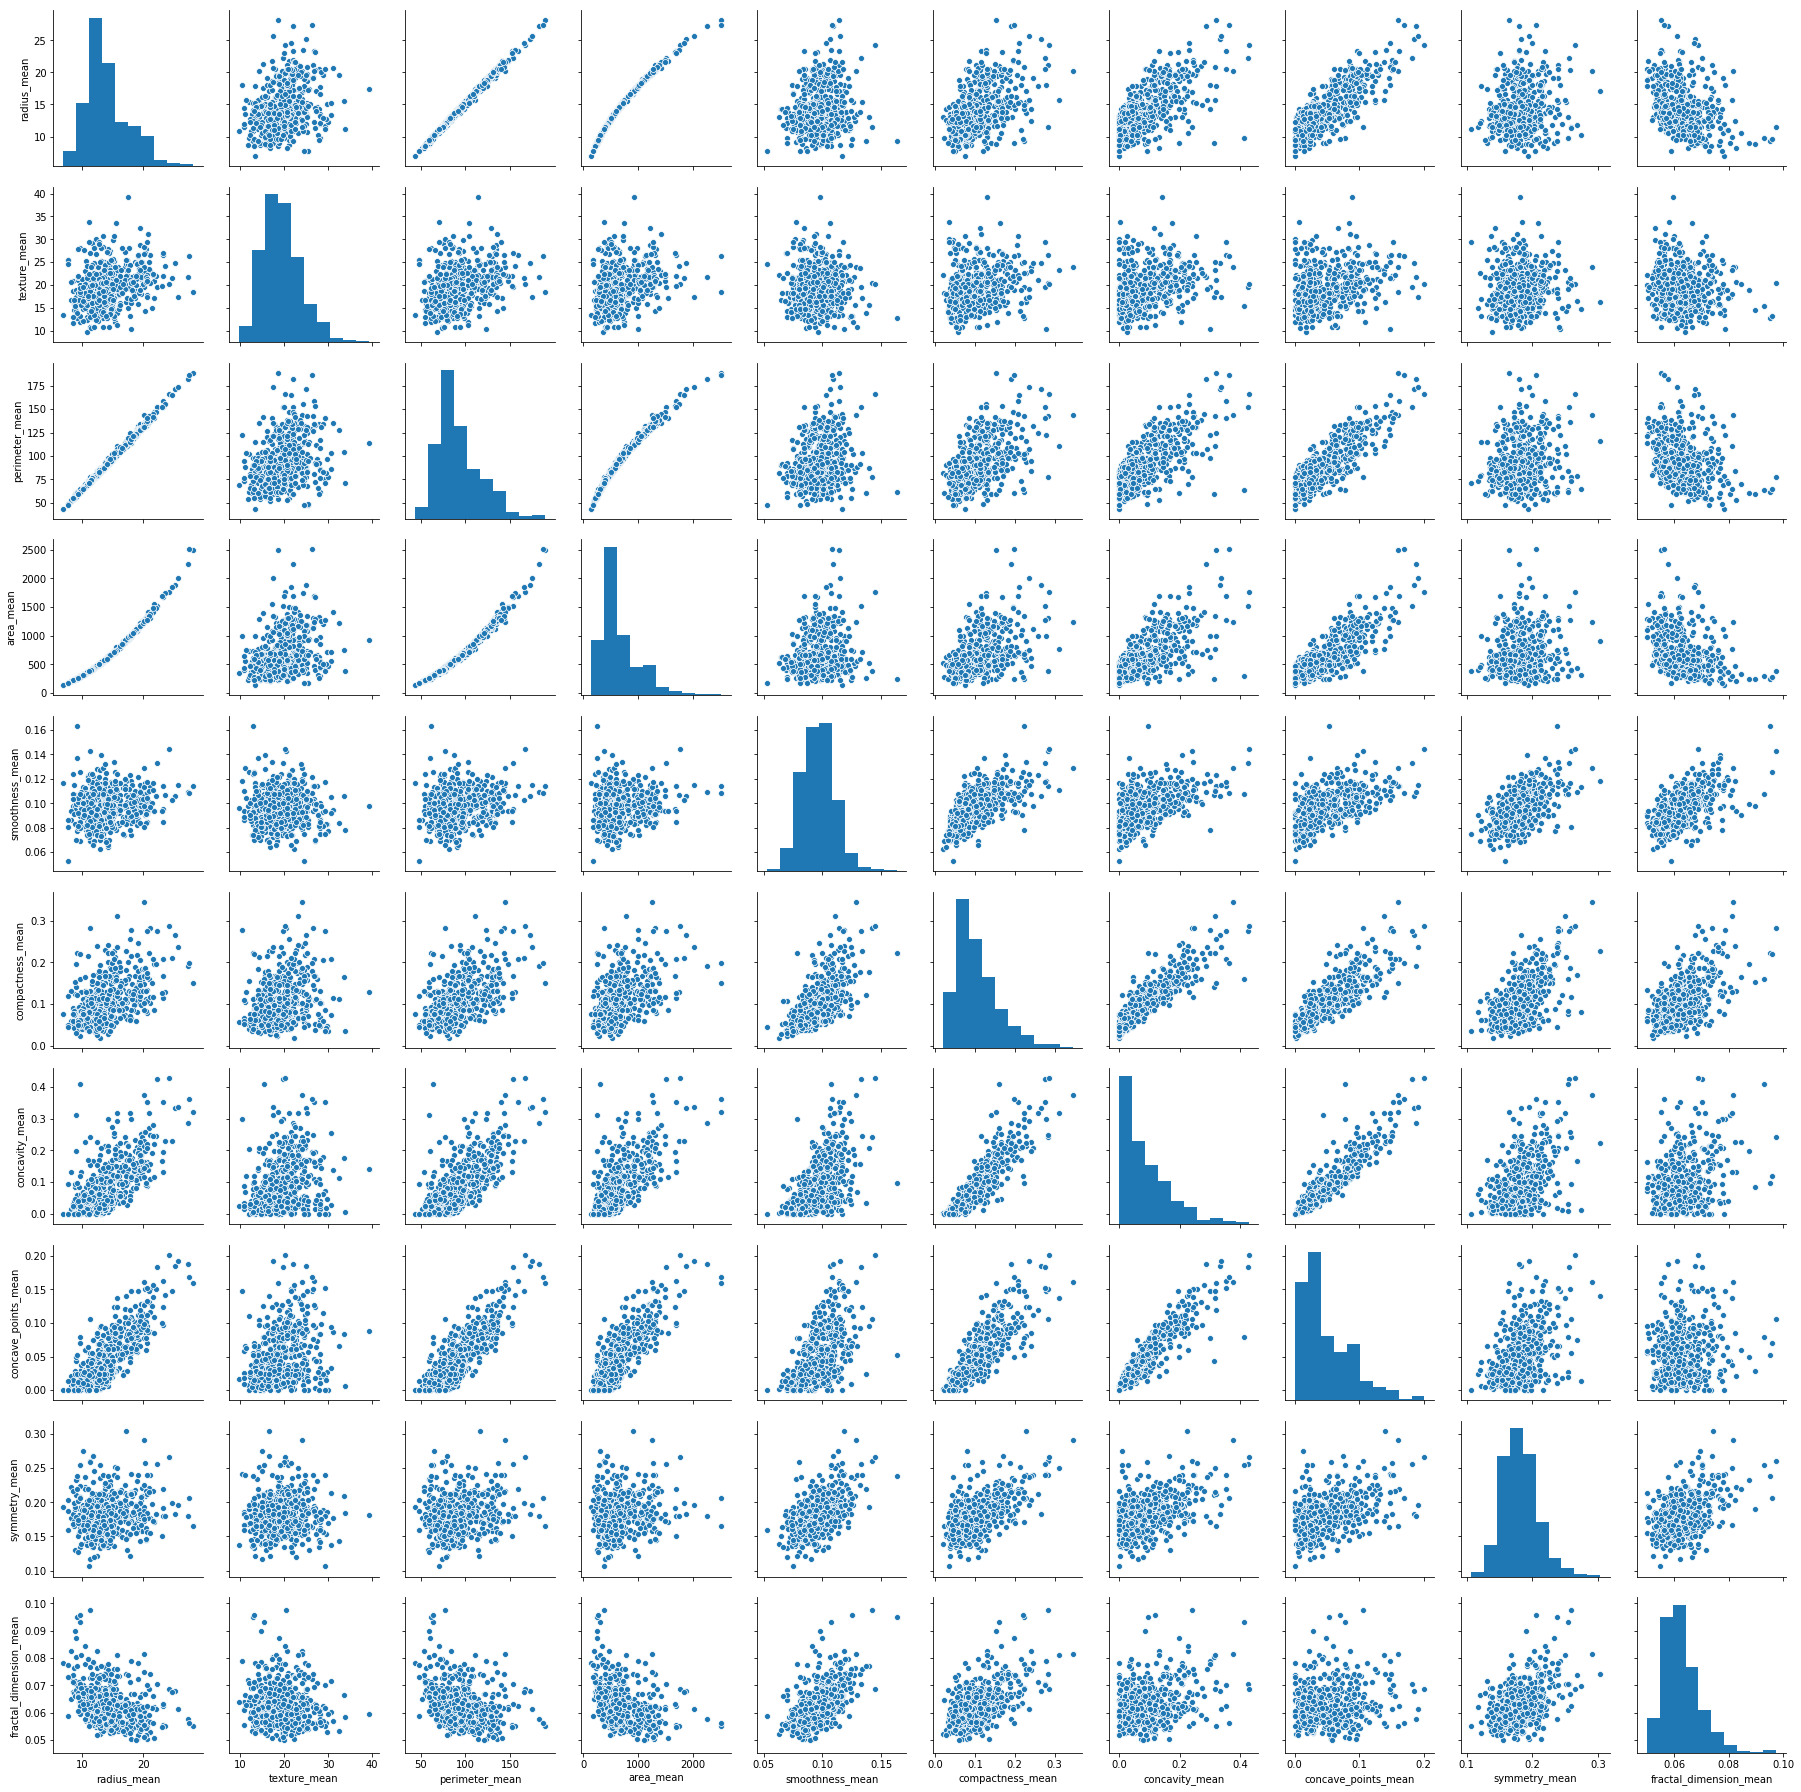

In [8]:
# Зависимость признаков
sns.pairplot(means)

## 6. Статистическая проверка взаимосвязей между переменными (pvalue)

Проверим взаимосвязь target-переменной c предоставленными признаками в наборе данных

In [9]:
def get_ols_string(target, array):
    values = " + ".join(np.delete(array, np.argwhere(array==target)))
    return "{0} ~ {1}".format(target, values)

In [10]:
est = smf.ols(get_ols_string('diagnosis', data.columns.values), data=data).fit()
est_res = est.summary()

# Изучим результат обучения линейной модели и 
# уберем все переменные первого порядка, для которых верна нулевая гипотеза
table = est_res.tables[1]
pd_table = pd.read_csv(StringIO(table.as_csv()))
pd_table.columns = ['column', 'coef', 'std_err', 't', 'p>t', '0.025', '0.975']

# Выбираем переменные первого порядка, для которых не верна нулевая гипотеза:
columns = pd_table.sort_values(by='p>t')[(pd_table['p>t']<0.4)].column.unique()
columns = [i.strip(' ') for i in columns]
columns.remove('Intercept')
columns

/Users/akirichenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


['radius_worst',
 'area_worst',
 'compactness_mean',
 'concavity_se',
 'smoothness_se',
 'concave_points_se',
 'fractal_dimension_worst',
 'concavity_worst',
 'radius_se',
 'concavity_mean',
 'radius_mean',
 'symmetry_worst',
 'concave_points_mean',
 'texture_worst',
 'perimeter_mean']

In [11]:
# Проверим результаты линейной регрессии на 
est = smf.ols(get_ols_string('diagnosis', columns), data=data).fit()
est_res = est.summary()
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.1184,0.187,-11.308,0.000,-2.486,-1.750
radius_worst,0.1766,0.022,7.895,0.000,0.133,0.221
area_worst,-0.0010,0.000,-7.654,0.000,-0.001,-0.001
compactness_mean,-3.8112,0.824,-4.626,0.000,-5.430,-2.193
concavity_se,-4.0005,1.048,-3.818,0.000,-6.059,-1.942
smoothness_se,19.4291,4.374,4.442,0.000,10.838,28.020
concave_points_se,10.3633,3.783,2.739,0.006,2.932,17.794
fractal_dimension_worst,3.7346,1.179,3.168,0.002,1.419,6.050
concavity_worst,0.5009,0.175,2.865,0.004,0.157,0.844
radius_se,0.1817,0.072,2.512,0.012,0.040,0.324


In [12]:
table.insert_header_row(rownum=0, headers=['column', 'coef', 'std_err', 't', 'p>t', '0.025', '0.975'])

## 7. Выбор стратегии Feature selection

Для того чтобы учитывались не только линейные зависимости при построении модели, расширим количество параметров и проведем для них статистический тест

Для расширения параметров попробуем включить в обучающую выборку нелинейные зависимости, например перемножим все коэффициенты со всеми и изучим результаты статистических тестов, чтобы избавиться от незначительных параметров

In [13]:
columns_cartesian = [' * '.join([i,j]) for i in columns for j in columns]

# Проверим результаты линейной регрессии
est = smf.ols(get_ols_string('diagnosis', columns+columns_cartesian), data=data).fit()
est_res = est.summary()

table = est_res.tables[1]
pd_table = pd.read_csv(StringIO(table.as_csv()))
pd_table.columns = ['column', 'coef', 'std_err', 't', 'p>t', '0.025', '0.975']
pd_table_filtered = pd_table.sort_values(by='p>t')[(pd_table['p>t']<0.2)]

/Users/akirichenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [14]:
# Cобираем итоговую выборку
# Для начала соберем все параметры первого порядка
columns = [i.strip(' ') for i in pd_table_filtered.column.unique()]
columns.remove('Intercept')
parameters = data[[i for i in columns if ':' not in i]]

# Теперь будем перемножать параметры второго порядка
for i in [i for i in columns if ':' in i]:
    i_values = i.split(":")
    parameters[i] = data.apply(lambda x: x[i_values[0]]*x[i_values[1]], axis=1)
                                                 

/Users/akirichenko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
# Подготовка данных для решения задачи
X = parameters
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.33, random_state=42)

## 8. Oversampling/Undersampling

Посмотрим на распределение значений для target-переменной

(array([236.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 145.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

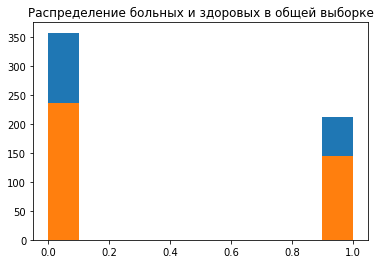

In [16]:
plt.title('Распределение больных и здоровых в общей выборке')
plt.hist(y)

plt.hist(y_train)

Количество доброкачественных тестов и злокачественных различается, что может повлиять на переобучение модели.
При этом количества данных в исходной выборке не очень много, поэтому попробуем применить стратегию Oversampling для уравновешивания обучающей выборки

In [17]:
# Библиотека для применения стратегии OVERSAMPLING
from imblearn.over_sampling import SMOTE

In [18]:
X_resampled_o, y_resampled_o = SMOTE().fit_resample(X, y)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_resampled_o, y_resampled_o,  test_size=0.33, 
                                                            random_state=42)

(array([235.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 243.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

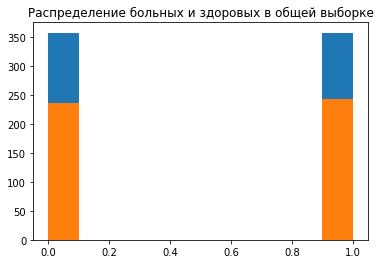

In [19]:
# Гистограмма общей выборки после применения стратегии OVERSAMPLING
plt.title('Распределение больных и здоровых в общей выборке')
plt.hist(y_resampled_o)

# Гистограмма обучающей выборки после применения стратегии OVERSAMPLING
plt.hist(y_train_o)

## 9. Модель. Задача классификации

### 9.1 Дерево решений

In [20]:
model_tree = DecisionTreeClassifier()

In [21]:
# Применяем Grid search для 
cross_val_score(model_tree, X_train_o, y_train_o, cv=10).mean()

0.9517196772325951

In [22]:
# Оценка модели на кросс-валидации без оверсэмплинга
cross_val_score(model_tree, X_train, y_train, cv=10).mean()

0.9363861837546047

In [23]:
model_tree.fit(X_train_o, y_train_o)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
tree_prediction = model_tree.predict(X_test)

### 9.2 Логистическая регрессия

In [25]:
model_logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')

In [26]:
# Оценка модели на кросс-валидации и оверсэмплинге
cross_val_score(model_logreg, X_train_o, y_train_o, cv=10).mean()

0.9706487914314662

In [27]:
# Оценка модели на кросс-валидации без оверсэмплинга
cross_val_score(model_logreg, X_train, y_train, cv=10).mean()

0.9654903891745997

In [28]:
model_logreg.fit(X_train_o, y_train_o)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
logreg_prediction = model_logreg.predict(X_test)
logreg_prediction_proba = model_logreg.predict_proba(X_test)

#### Очевидно, овэрсэмплинг для данной задачи дает значительный прирост к точности модели, независимо от ее типа

## 10. Проверка качества классификации с помощью метрик

### 10.1 Accuracy

$$ Accuracy=P/N $$
где, P – количество документов по которым классификатор принял правильное решение, а N – размер обучающей выборки.

In [30]:
from sklearn.metrics import accuracy_score
# Точность для дерева решений:
accuracy_score(y_test, tree_prediction)

0.9893617021276596

In [31]:
# Точность для логистической регрессии:
accuracy_score(y_test, logreg_prediction)

0.973404255319149

### 10.2 F1-Score

Понятно что чем выше точность и полнота, тем лучше. Но в реальной жизни максимальная точность и полнота не достижимы одновременно и приходится искать некий баланс. Поэтому, хотелось бы иметь некую метрику которая объединяла бы в себе информацию о точности и полноте нашего алгоритма. 

F-мера представляет собой гармоническое среднее между точностью и полнотой. Она стремится к нулю, если точность или полнота стремится к нулю.

$$ F=2\dfrac{Precision×Recall}{Precision+Recall} $$

In [32]:
from sklearn.metrics import f1_score
# F1-score для дерева решений:
f1_score(y_test, tree_prediction)

0.9850746268656716

In [33]:
# F1-score для логистической регрессии:
f1_score(y_test, logreg_prediction)

0.962962962962963

### 10.3 Precision-Recall

Пусть

- TP — истино-положительное решение;
- TN — истино-отрицательное решение;
- FP — ложно-положительное решение;
- FN — ложно-отрицательное решение.
Тогда, точность и полнота определяются следующим образом:

$$ Precision=TP/(TP+FP) $$
$$ Recall=TP/(TP+FN) $$

Precision - количество истинно положительных результатов от количества модельно-положительных результатов (фактически точность модели)
Recall - количество истинно положительных относительно реально-положительных результатов (фактически отклик на реальность)


In [34]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

In [35]:
# для логистической регрессии
print("Для логистической регрессии: Precision = {0}; Recall = {1}".\
    format(precision_score(y_test, logreg_prediction), recall_score(y_test, logreg_prediction)))

# для дерева решений
recall_score(y_test, tree_prediction)
print("Для дерева решений: Precision = {0}; Recall = {1}".\
    format(precision_score(y_test, tree_prediction), recall_score(y_test, tree_prediction)))

Для логистической регрессии: Precision = 0.9558823529411765; Recall = 0.9701492537313433
Для дерева решений: Precision = 0.9850746268656716; Recall = 0.9850746268656716


/Users/akirichenko/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


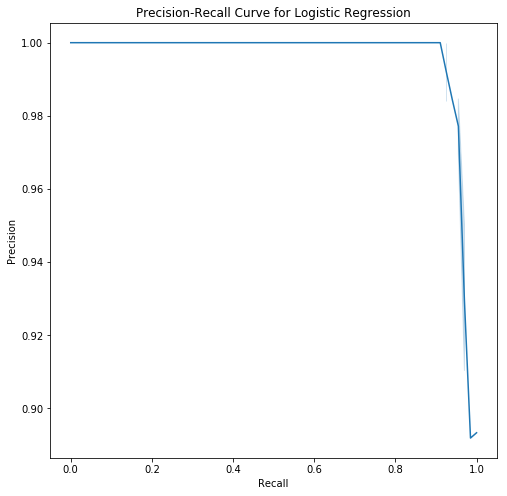

In [36]:
# Построим кривую Precision-Recall для Логистической регрессии
precision, recall, thresholds = precision_recall_curve(y_test, 
                                    [i[1] for i in logreg_prediction_proba])

plt.figure(figsize=(8,8))
plt.title('Precision-Recall Curve for Logistic Regression')
plt.rcParams.update({'font.size': 22})
plt.xlabel("Recall")
plt.ylabel("Precision")
sns.lineplot(recall, precision)

### 10.4 Confusion matrix (Матрица неточностей)

Столбцы этой матрицы резервируются за экспертными решениями, а строки за решениями классификатора. 

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
# Confusion matrix для линейной регрессии
confusion_matrix(y_test, logreg_prediction)

array([[118,   3],
       [  2,  65]])

In [39]:
# Confusion matrix для дерева решений
confusion_matrix(y_test, tree_prediction)

array([[120,   1],
       [  1,  66]])

## 11. Качество вероятности класса с помощью метрики Brier Score

The most common formulation of the Brier score is

$$ BS={\frac {1}{N}}\sum \limits _{t=1}^{N}(f_{t}-o_{t})^{2} $$
in which  $f_{t}$ is the probability that was forecast,  $o_{t}$ the actual outcome of the event at instance  t (0   if it does not happen and  1 if it does happen) and N is the number of forecasting instances.

In [40]:
from sklearn.metrics import brier_score_loss

In [41]:
brier_score_loss(y_test, [i[1] for i in logreg_prediction_proba])

0.019565043373688105